In [1]:
import sys
sys.path.append("../")
import numpy as np
from girg import *
from copy import deepcopy
from numba import njit
import matplotlib.pyplot as plt

In [2]:
N = 10000 + 940

### il

m = 2    # connection number # 2 [in BA]
seed = 123

######################

alpha = 2
tau = 2.5
np.random.seed(seed)
Girg = GIRG(vertex_size=N, alpha=alpha, tau=tau, expected_weight=1, on_torus=False, dimension=2)
np.random.seed(seed)
el_, locations = Girg.generate_graph(locations=Girg.vertex_locations, weights=Girg.vertex_weights)

connected_components = sorted(list(el_.subgraph(c) for c in nx.connected_components(el_)), key=len, reverse=True)

el = connected_components[0]

am = nx.to_numpy_matrix(el)

el = nx.Graph(am)

N = len(el)

el_degs = np.array(el.degree())[:,1]

###########################################

m = 2
il = nx.barabasi_albert_graph(N,m,seed=seed)

il_degs = np.array(il.degree())[:,1]

In [3]:
print(max(il_degs),max(el_degs))

218 856


In [4]:
j_max = max(il_degs)
k_max = max(el_degs)

il_mean_degree = np.mean(il_degs)
el_mean_degree = np.mean(el_degs)

js = np.arange(0, j_max+1, 1)
ks = np.arange(0, k_max+1, 1)

il_n_k = np.zeros(j_max+1)
for j in il_degs:
    il_n_k[j] += 1

el_n_k = np.zeros(k_max+1)
for k in el_degs:
    el_n_k[k] += 1

In [5]:
il_mean_degree, el_mean_degree

(3.9992019950124686, 5.727082294264339)

In [6]:
el_n_k, il_n_k = el_n_k/sum(el_n_k), il_n_k/sum(il_n_k)

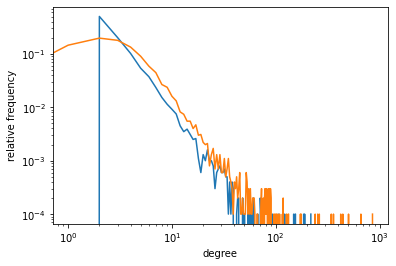

In [7]:
plt.figure()
plt.plot(js, il_n_k)
plt.plot(ks, el_n_k)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"degree")
plt.ylabel(r"relative frequency")
plt.show()

In [8]:
j_max = 210#max(il_degs)
k_max = 400#max(el_degs)

js = np.arange(0, j_max+1, 1)
ks = np.arange(0, k_max+1, 1)

In [9]:
# il

kappa = 1 # il : u(i) -> a
lambd = 0.5*kappa # il : u -> a
delta = 1/30 # forgetness : a -> u

# el

beta_u = 0.17 # el : s(u) -> e # 0.17 (tau=2.5 : long range), 0.6 (tau=3.5 : short range)
beta_a = 0.2*beta_u # el : s(a) -> e
sigma = 1/5 # el : e -> i
f = 0.01 # fatality
gamma = 1/14 # resolution

In [10]:
US_j_k = np.zeros((len(js),len(ks)))
AS_j_k = np.zeros((len(js),len(ks)))

UI_j_k = np.zeros((len(js),len(ks)))
AI_j_k = np.zeros((len(js),len(ks)))

UE_j_k = np.zeros((len(js),len(ks))) 
AE_j_k = np.zeros((len(js),len(ks)))

UR_j_k = np.zeros((len(js),len(ks)))
AR_j_k = np.zeros((len(js),len(ks)))

UD_j_k = np.zeros((len(js),len(ks)))

In [11]:
i0, a0 = 1e-3, 1e-4

In [12]:
for j in range(len(js)):
    for k in range(len(ks)):
        p_jk = il_n_k[j]*el_n_k[k]
        
        AI_j_k[j][k] = p_jk * a0/2
        UI_j_k[j][k] = p_jk * (i0-a0/2)
        AS_j_k[j][k] = p_jk * a0/2
        US_j_k[j][k] = p_jk * (1-i0-a0/2)

In [13]:
sum(sum(US_j_k)),sum(sum(AS_j_k)),sum(sum(UI_j_k)),sum(sum(AI_j_k))

(0.9983521743869763,
 4.997007730051419e-05,
 0.0009494314687097707,
 4.997007730051419e-05)

In [14]:
sum(sum(US_j_k))+sum(sum(AS_j_k))+sum(sum(UI_j_k))+sum(sum(AI_j_k))

0.9994015460102872

In [15]:
@njit
def sys(y, t, kappa, lambd, delta, beta_u, beta_a, sigma, f, gamma):
    
    US_j_k = y[:len(js)*len(ks)].reshape(len(js),len(ks))
    AS_j_k = y[len(js)*len(ks):2*len(js)*len(ks)].reshape(len(js),len(ks))
    UE_j_k = y[2*len(js)*len(ks):3*len(js)*len(ks)].reshape(len(js),len(ks))
    AE_j_k = y[3*len(js)*len(ks):4*len(js)*len(ks)].reshape(len(js),len(ks))
    UI_j_k = y[4*len(js)*len(ks):5*len(js)*len(ks)].reshape(len(js),len(ks))
    AI_j_k = y[5*len(js)*len(ks):6*len(js)*len(ks)].reshape(len(js),len(ks))
    UR_j_k = y[6*len(js)*len(ks):7*len(js)*len(ks)].reshape(len(js),len(ks))
    AR_j_k = y[7*len(js)*len(ks):8*len(js)*len(ks)].reshape(len(js),len(ks))
    UD_j_k = y[8*len(js)*len(ks):9*len(js)*len(ks)].reshape(len(js),len(ks))
    
    sum_A = np.sum(np.array([jp*(np.sum(AS_j_k[jp,:])+np.sum(AE_j_k[jp,:])+np.sum(AI_j_k[jp,:])+np.sum(AR_j_k[jp,:])) for jp in js]))/il_mean_degree
    sum_I = np.sum(np.array([kp*(np.sum(UI_j_k[:,kp])+np.sum(AI_j_k[:,kp])) for kp in ks]))/el_mean_degree
    
    mat_dUSdt = np.zeros((len(js),len(ks)))
    mat_dASdt = np.zeros((len(js),len(ks)))
    mat_dUEdt = np.zeros((len(js),len(ks)))
    mat_dAEdt = np.zeros((len(js),len(ks)))
    mat_dUIdt = np.zeros((len(js),len(ks)))
    mat_dAIdt = np.zeros((len(js),len(ks)))
    mat_dURdt = np.zeros((len(js),len(ks)))
    mat_dARdt = np.zeros((len(js),len(ks)))
    mat_dUDdt = np.zeros((len(js),len(ks)))
    
    for j in js:
        for k in ks:
            mat_dUSdt[j,k] = -lambd*sum_A*j*US_j_k[j,k] - beta_u*sum_I*k*US_j_k[j,k] + delta*AS_j_k[j,k]
            mat_dASdt[j,k] = lambd*sum_A*j*US_j_k[j,k] - beta_a*sum_I*k*AS_j_k[j,k] - delta*AS_j_k[j,k]
            mat_dUEdt[j,k] = -lambd*sum_A*j*UE_j_k[j,k] + beta_u*sum_I*k*US_j_k[j,k] - sigma*UE_j_k[j,k] + delta*AE_j_k[j,k]
            mat_dAEdt[j,k] = lambd*sum_A*j*UE_j_k[j,k] + beta_a*sum_I*k*AS_j_k[j,k] - sigma*AE_j_k[j,k] - delta*AE_j_k[j,k]
            mat_dUIdt[j,k] = -lambd*sum_A*j*UI_j_k[j,k] + sigma*UE_j_k[j,k] - gamma*UI_j_k[j,k] - kappa*UI_j_k[j,k] + delta*AI_j_k[j,k]
            mat_dAIdt[j,k] = lambd*sum_A*j*UI_j_k[j,k] + sigma*AE_j_k[j,k] - gamma*AI_j_k[j,k] + kappa*UI_j_k[j,k] - delta*AI_j_k[j,k]
            mat_dURdt[j,k] = -lambd*sum_A*j*UR_j_k[j,k] + (1-f)*gamma*UI_j_k[j,k] + delta*AR_j_k[j,k]
            mat_dARdt[j,k] = lambd*sum_A*j*UR_j_k[j,k] + (1-f)*gamma*AI_j_k[j,k] - delta*AR_j_k[j,k]
            mat_dUDdt[j,k] = f*gamma*(UI_j_k[j,k]+AI_j_k[j,k])
    
    
    dquantitiesdt = np.concatenate((mat_dUSdt.ravel(), mat_dASdt.ravel(), mat_dUEdt.ravel(), \
                              mat_dAEdt.ravel(), mat_dUIdt.ravel(), mat_dAIdt.ravel(), \
                              mat_dURdt.ravel(), mat_dARdt.ravel(), mat_dUDdt.ravel()))

    return dquantitiesdt

In [16]:
# initial conditions vector
initial_quantities = np.array([US_j_k, AS_j_k, UE_j_k, AE_j_k, UI_j_k, AI_j_k, UR_j_k, AR_j_k, UD_j_k])

y0 = initial_quantities.flatten()
print(y0.shape)

# integrate the ODEs over the time grid, ts
delta_t = 1e-2
ret = []#odeint(sys, y0, ts, args=(kappa, lambd, delta, beta_u, beta_a, sigma, f, gamma), hmin=0.1, hmax=10)
ret.append(deepcopy(y0))
t_arr = []
t_arr.append(0)

for it in range(15000):
    y0 += delta_t*sys(y0, 0, kappa, lambd, delta, beta_u, beta_a, sigma, f, gamma)
    if it % 10 == 0:
        ret.append(deepcopy(y0))
        t_arr.append(delta_t*(it+1))
        print("iteration",it)

(761499,)
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iterati

iteration 5560
iteration 5570
iteration 5580
iteration 5590
iteration 5600
iteration 5610
iteration 5620
iteration 5630
iteration 5640
iteration 5650
iteration 5660
iteration 5670
iteration 5680
iteration 5690
iteration 5700
iteration 5710
iteration 5720
iteration 5730
iteration 5740
iteration 5750
iteration 5760
iteration 5770
iteration 5780
iteration 5790
iteration 5800
iteration 5810
iteration 5820
iteration 5830
iteration 5840
iteration 5850
iteration 5860
iteration 5870
iteration 5880
iteration 5890
iteration 5900
iteration 5910
iteration 5920
iteration 5930
iteration 5940
iteration 5950
iteration 5960
iteration 5970
iteration 5980
iteration 5990
iteration 6000
iteration 6010
iteration 6020
iteration 6030
iteration 6040
iteration 6050
iteration 6060
iteration 6070
iteration 6080
iteration 6090
iteration 6100
iteration 6110
iteration 6120
iteration 6130
iteration 6140
iteration 6150
iteration 6160
iteration 6170
iteration 6180
iteration 6190
iteration 6200
iteration 6210
iteration 

iteration 10960
iteration 10970
iteration 10980
iteration 10990
iteration 11000
iteration 11010
iteration 11020
iteration 11030
iteration 11040
iteration 11050
iteration 11060
iteration 11070
iteration 11080
iteration 11090
iteration 11100
iteration 11110
iteration 11120
iteration 11130
iteration 11140
iteration 11150
iteration 11160
iteration 11170
iteration 11180
iteration 11190
iteration 11200
iteration 11210
iteration 11220
iteration 11230
iteration 11240
iteration 11250
iteration 11260
iteration 11270
iteration 11280
iteration 11290
iteration 11300
iteration 11310
iteration 11320
iteration 11330
iteration 11340
iteration 11350
iteration 11360
iteration 11370
iteration 11380
iteration 11390
iteration 11400
iteration 11410
iteration 11420
iteration 11430
iteration 11440
iteration 11450
iteration 11460
iteration 11470
iteration 11480
iteration 11490
iteration 11500
iteration 11510
iteration 11520
iteration 11530
iteration 11540
iteration 11550
iteration 11560
iteration 11570
iteratio

In [17]:
s_arr_sr = []
e_arr_sr = []
i_arr_sr = []
r_arr_sr = []
d_arr_sr = []
a_arr_sr = []
u_arr_sr = []
t_arr_2_sr = []

for it in range(len(ret)):
    if it % 1 == 0:
        s_arr_sr.append(sum(ret[it][:len(js)*len(ks)]+ret[it][len(js)*len(ks):2*len(js)*len(ks)]))
        e_arr_sr.append(sum(ret[it][2*len(js)*len(ks):3*len(js)*len(ks)]+ret[it][3*len(js)*len(ks):4*len(js)*len(ks)]))
        i_arr_sr.append(sum(ret[it][4*len(js)*len(ks):5*len(js)*len(ks)]+ret[it][5*len(js)*len(ks):6*len(js)*len(ks)]))
        r_arr_sr.append(sum(ret[it][6*len(js)*len(ks):7*len(js)*len(ks)]+ret[it][7*len(js)*len(ks):8*len(js)*len(ks)]))
        d_arr_sr.append(sum(ret[it][8*len(js)*len(ks):9*len(js)*len(ks)]))
        u_arr_sr.append(sum(ret[it][:len(js)*len(ks)]+ret[it][2*len(js)*len(ks):3*len(js)*len(ks)]+\
                         ret[it][4*len(js)*len(ks):5*len(js)*len(ks)]+ret[it][6*len(js)*len(ks):7*len(js)*len(ks)]+\
                        +ret[it][8*len(js)*len(ks):9*len(js)*len(ks)]))
        a_arr_sr.append(sum(ret[it][len(js)*len(ks):2*len(js)*len(ks)]+ret[it][3*len(js)*len(ks):4*len(js)*len(ks)]+\
                         ret[it][5*len(js)*len(ks):6*len(js)*len(ks)]+ret[it][7*len(js)*len(ks):8*len(js)*len(ks)]))
            
        t_arr_2_sr.append(t_arr[it])

In [18]:
s_arr_sr = np.array(s_arr_sr)
e_arr_sr = np.array(e_arr_sr)
i_arr_sr = np.array(i_arr_sr)
r_arr_sr = np.array(r_arr_sr)
d_arr_sr = np.array(d_arr_sr)
a_arr_sr = np.array(a_arr_sr)
u_arr_sr = np.array(u_arr_sr)
t_arr_2_sr = np.array(t_arr_2_sr)

In [19]:
N = 10000 + 245

### il

m = 2    # connection number # 2 [in BA]
seed = 123

######################

alpha = 2
tau = 3.5
np.random.seed(seed)
Girg = GIRG(vertex_size=N, alpha=alpha, tau=tau, expected_weight=1, on_torus=False, dimension=2)
np.random.seed(seed)
el_, locations = Girg.generate_graph(locations=Girg.vertex_locations, weights=Girg.vertex_weights)

connected_components = sorted(list(el_.subgraph(c) for c in nx.connected_components(el_)), key=len, reverse=True)

el = connected_components[0]

am = nx.to_numpy_matrix(el)

el = nx.Graph(am)

N = len(el)

el_degs = np.array(el.degree())[:,1]

###########################################

m = 2
il = nx.barabasi_albert_graph(N,m,seed=seed)

il_degs = np.array(il.degree())[:,1]

In [20]:
print(max(il_degs),max(el_degs))

218 164


In [21]:
j_max = max(il_degs)
k_max = max(el_degs)

il_mean_degree = np.mean(il_degs)
el_mean_degree = np.mean(el_degs)

js = np.arange(0, j_max+1, 1)
ks = np.arange(0, k_max+1, 1)

il_n_k = np.zeros(j_max+1)
for j in il_degs:
    il_n_k[j] += 1

el_n_k = np.zeros(k_max+1)
for k in el_degs:
    el_n_k[k] += 1

In [22]:
el_n_k, il_n_k = el_n_k/sum(el_n_k), il_n_k/sum(il_n_k)

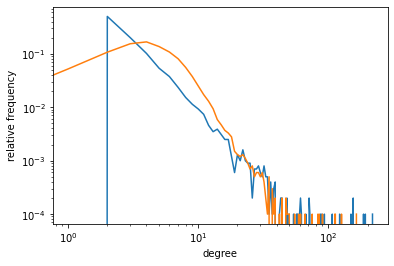

In [23]:
plt.figure()
plt.plot(js, il_n_k)
plt.plot(ks, el_n_k)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"degree")
plt.ylabel(r"relative frequency")
plt.show()

In [24]:
j_max = 210#max(il_degs)
k_max = 164#max(el_degs)

js = np.arange(0, j_max+1, 1)
ks = np.arange(0, k_max+1, 1)

In [25]:
# il

kappa = 1 # il : u(i) -> a
lambd = 0.5*kappa # il : u -> a
delta = 1/30 # forgetness : a -> u

# el

beta_u = 0.6 # el : s(u) -> e # 0.17 (tau=2.5 : long range), 0.6 (tau=3.5 : short range)
beta_a = 0.2*beta_u # el : s(a) -> e
sigma = 1/5 # el : e -> i
f = 0.01 # fatality
gamma = 1/14 # resolution

In [26]:
US_j_k = np.zeros((len(js),len(ks)))
AS_j_k = np.zeros((len(js),len(ks)))

UI_j_k = np.zeros((len(js),len(ks)))
AI_j_k = np.zeros((len(js),len(ks)))

UE_j_k = np.zeros((len(js),len(ks))) 
AE_j_k = np.zeros((len(js),len(ks)))

UR_j_k = np.zeros((len(js),len(ks)))
AR_j_k = np.zeros((len(js),len(ks)))

UD_j_k = np.zeros((len(js),len(ks)))

In [27]:
i0, a0 = 1e-3, 1e-4

In [28]:
for j in range(len(js)):
    for k in range(len(ks)):
        p_jk = il_n_k[j]*el_n_k[k]
        
        AI_j_k[j][k] = p_jk * a0/2
        UI_j_k[j][k] = p_jk * (i0-a0/2)
        AS_j_k[j][k] = p_jk * a0/2
        US_j_k[j][k] = p_jk * (1-i0-a0/2)

In [29]:
@njit
def sys(y, t, kappa, lambd, delta, beta_u, beta_a, sigma, f, gamma):
    
    US_j_k = y[:len(js)*len(ks)].reshape(len(js),len(ks))
    AS_j_k = y[len(js)*len(ks):2*len(js)*len(ks)].reshape(len(js),len(ks))
    UE_j_k = y[2*len(js)*len(ks):3*len(js)*len(ks)].reshape(len(js),len(ks))
    AE_j_k = y[3*len(js)*len(ks):4*len(js)*len(ks)].reshape(len(js),len(ks))
    UI_j_k = y[4*len(js)*len(ks):5*len(js)*len(ks)].reshape(len(js),len(ks))
    AI_j_k = y[5*len(js)*len(ks):6*len(js)*len(ks)].reshape(len(js),len(ks))
    UR_j_k = y[6*len(js)*len(ks):7*len(js)*len(ks)].reshape(len(js),len(ks))
    AR_j_k = y[7*len(js)*len(ks):8*len(js)*len(ks)].reshape(len(js),len(ks))
    UD_j_k = y[8*len(js)*len(ks):9*len(js)*len(ks)].reshape(len(js),len(ks))
    
    sum_A = np.sum(np.array([jp*(np.sum(AS_j_k[jp,:])+np.sum(AE_j_k[jp,:])+np.sum(AI_j_k[jp,:])+np.sum(AR_j_k[jp,:])) for jp in js]))/il_mean_degree
    sum_I = np.sum(np.array([kp*(np.sum(UI_j_k[:,kp])+np.sum(AI_j_k[:,kp])) for kp in ks]))/el_mean_degree
    
    mat_dUSdt = np.zeros((len(js),len(ks)))
    mat_dASdt = np.zeros((len(js),len(ks)))
    mat_dUEdt = np.zeros((len(js),len(ks)))
    mat_dAEdt = np.zeros((len(js),len(ks)))
    mat_dUIdt = np.zeros((len(js),len(ks)))
    mat_dAIdt = np.zeros((len(js),len(ks)))
    mat_dURdt = np.zeros((len(js),len(ks)))
    mat_dARdt = np.zeros((len(js),len(ks)))
    mat_dUDdt = np.zeros((len(js),len(ks)))
    
    for j in js:
        for k in ks:
            mat_dUSdt[j,k] = -lambd*sum_A*j*US_j_k[j,k] - beta_u*sum_I*k*US_j_k[j,k] + delta*AS_j_k[j,k]
            mat_dASdt[j,k] = lambd*sum_A*j*US_j_k[j,k] - beta_a*sum_I*k*AS_j_k[j,k] - delta*AS_j_k[j,k]
            mat_dUEdt[j,k] = -lambd*sum_A*j*UE_j_k[j,k] + beta_u*sum_I*k*US_j_k[j,k] - sigma*UE_j_k[j,k] + delta*AE_j_k[j,k]
            mat_dAEdt[j,k] = lambd*sum_A*j*UE_j_k[j,k] + beta_a*sum_I*k*AS_j_k[j,k] - sigma*AE_j_k[j,k] - delta*AE_j_k[j,k]
            mat_dUIdt[j,k] = -lambd*sum_A*j*UI_j_k[j,k] + sigma*UE_j_k[j,k] - gamma*UI_j_k[j,k] - kappa*UI_j_k[j,k] + delta*AI_j_k[j,k]
            mat_dAIdt[j,k] = lambd*sum_A*j*UI_j_k[j,k] + sigma*AE_j_k[j,k] - gamma*AI_j_k[j,k] + kappa*UI_j_k[j,k] - delta*AI_j_k[j,k]
            mat_dURdt[j,k] = -lambd*sum_A*j*UR_j_k[j,k] + (1-f)*gamma*UI_j_k[j,k] + delta*AR_j_k[j,k]
            mat_dARdt[j,k] = lambd*sum_A*j*UR_j_k[j,k] + (1-f)*gamma*AI_j_k[j,k] - delta*AR_j_k[j,k]
            mat_dUDdt[j,k] = f*gamma*(UI_j_k[j,k]+AI_j_k[j,k])
    
    
    dquantitiesdt = np.concatenate((mat_dUSdt.ravel(), mat_dASdt.ravel(), mat_dUEdt.ravel(), \
                              mat_dAEdt.ravel(), mat_dUIdt.ravel(), mat_dAIdt.ravel(), \
                              mat_dURdt.ravel(), mat_dARdt.ravel(), mat_dUDdt.ravel()))

    return dquantitiesdt

In [30]:
# initial conditions vector
initial_quantities = np.array([US_j_k, AS_j_k, UE_j_k, AE_j_k, UI_j_k, AI_j_k, UR_j_k, AR_j_k, UD_j_k])

y0 = initial_quantities.flatten()
print(y0.shape)

# integrate the ODEs over the time grid, ts
delta_t = 1e-2
ret = []#odeint(sys, y0, ts, args=(kappa, lambd, delta, beta_u, beta_a, sigma, f, gamma), hmin=0.1, hmax=10)
ret.append(deepcopy(y0))
t_arr = []
t_arr.append(0)

for it in range(15000):
    y0 += delta_t*sys(y0, 0, kappa, lambd, delta, beta_u, beta_a, sigma, f, gamma)
    if it % 10 == 0:
        ret.append(deepcopy(y0))
        t_arr.append(delta_t*(it+1))
        print("iteration",it)

(313335,)
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iterati

iteration 5690
iteration 5700
iteration 5710
iteration 5720
iteration 5730
iteration 5740
iteration 5750
iteration 5760
iteration 5770
iteration 5780
iteration 5790
iteration 5800
iteration 5810
iteration 5820
iteration 5830
iteration 5840
iteration 5850
iteration 5860
iteration 5870
iteration 5880
iteration 5890
iteration 5900
iteration 5910
iteration 5920
iteration 5930
iteration 5940
iteration 5950
iteration 5960
iteration 5970
iteration 5980
iteration 5990
iteration 6000
iteration 6010
iteration 6020
iteration 6030
iteration 6040
iteration 6050
iteration 6060
iteration 6070
iteration 6080
iteration 6090
iteration 6100
iteration 6110
iteration 6120
iteration 6130
iteration 6140
iteration 6150
iteration 6160
iteration 6170
iteration 6180
iteration 6190
iteration 6200
iteration 6210
iteration 6220
iteration 6230
iteration 6240
iteration 6250
iteration 6260
iteration 6270
iteration 6280
iteration 6290
iteration 6300
iteration 6310
iteration 6320
iteration 6330
iteration 6340
iteration 

iteration 11110
iteration 11120
iteration 11130
iteration 11140
iteration 11150
iteration 11160
iteration 11170
iteration 11180
iteration 11190
iteration 11200
iteration 11210
iteration 11220
iteration 11230
iteration 11240
iteration 11250
iteration 11260
iteration 11270
iteration 11280
iteration 11290
iteration 11300
iteration 11310
iteration 11320
iteration 11330
iteration 11340
iteration 11350
iteration 11360
iteration 11370
iteration 11380
iteration 11390
iteration 11400
iteration 11410
iteration 11420
iteration 11430
iteration 11440
iteration 11450
iteration 11460
iteration 11470
iteration 11480
iteration 11490
iteration 11500
iteration 11510
iteration 11520
iteration 11530
iteration 11540
iteration 11550
iteration 11560
iteration 11570
iteration 11580
iteration 11590
iteration 11600
iteration 11610
iteration 11620
iteration 11630
iteration 11640
iteration 11650
iteration 11660
iteration 11670
iteration 11680
iteration 11690
iteration 11700
iteration 11710
iteration 11720
iteratio

In [31]:
s_arr_lr = []
e_arr_lr = []
i_arr_lr = []
r_arr_lr = []
d_arr_lr = []
a_arr_lr = []
u_arr_lr = []
t_arr_2_lr = []

for it in range(len(ret)):
    if it % 1 == 0:
        s_arr_lr.append(sum(ret[it][:len(js)*len(ks)]+ret[it][len(js)*len(ks):2*len(js)*len(ks)]))
        e_arr_lr.append(sum(ret[it][2*len(js)*len(ks):3*len(js)*len(ks)]+ret[it][3*len(js)*len(ks):4*len(js)*len(ks)]))
        i_arr_lr.append(sum(ret[it][4*len(js)*len(ks):5*len(js)*len(ks)]+ret[it][5*len(js)*len(ks):6*len(js)*len(ks)]))
        r_arr_lr.append(sum(ret[it][6*len(js)*len(ks):7*len(js)*len(ks)]+ret[it][7*len(js)*len(ks):8*len(js)*len(ks)]))
        d_arr_lr.append(sum(ret[it][8*len(js)*len(ks):9*len(js)*len(ks)]))
        u_arr_lr.append(sum(ret[it][:len(js)*len(ks)]+ret[it][2*len(js)*len(ks):3*len(js)*len(ks)]+\
                         ret[it][4*len(js)*len(ks):5*len(js)*len(ks)]+ret[it][6*len(js)*len(ks):7*len(js)*len(ks)]+\
                        +ret[it][8*len(js)*len(ks):9*len(js)*len(ks)]))
        a_arr_lr.append(sum(ret[it][len(js)*len(ks):2*len(js)*len(ks)]+ret[it][3*len(js)*len(ks):4*len(js)*len(ks)]+\
                         ret[it][5*len(js)*len(ks):6*len(js)*len(ks)]+ret[it][7*len(js)*len(ks):8*len(js)*len(ks)]))
            
        t_arr_2_lr.append(t_arr[it])

In [32]:
s_arr_lr = np.array(s_arr_lr)
e_arr_lr = np.array(e_arr_lr)
i_arr_lr = np.array(i_arr_lr)
r_arr_lr = np.array(r_arr_lr)
d_arr_lr = np.array(d_arr_lr)
a_arr_lr = np.array(a_arr_lr)
u_arr_lr = np.array(u_arr_lr)
t_arr_2_lr = np.array(t_arr_2_lr)

In [33]:
from matplotlib import rcParams
import matplotlib.ticker as ticker
import seaborn as sns

# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 8,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 0.5*510 # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width * ratio  # height in inches
fig_size = [fig_width, 1.5*fig_height]
rcParams.update({'figure.figsize': fig_size})

In [34]:
#sns.set_context("paper")

/home/lucasb/anaconda3/envs/TCR/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


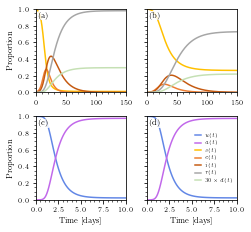

In [35]:
#fig, ax = plt.subplots(ncols=3)
mosaic = """
    AB
    CD
    """

fig = plt.figure(constrained_layout=True)

ax = fig.subplot_mosaic(mosaic)
fig.patch.set_facecolor('white')

ax["A"].plot(t_arr_2_lr,s_arr_lr,color="#ffc000",linewidth=1.5,label=r"$S(t)$")   
ax["A"].plot(t_arr_2_lr,e_arr_lr,color="#ed7d31",linewidth=1.5,label=r"$E(t)$")  
ax["A"].plot(t_arr_2_lr,i_arr_lr,color="#c55a11",linewidth=1.5,label=r"$I(t)$")  
ax["A"].plot(t_arr_2_lr,r_arr_lr,color="#a6a6a6",linewidth=1.5,label=r"$R(t)$")       
ax["A"].plot(t_arr_2_lr,3e1*d_arr_lr,color="#c5e0b4",linewidth=1.5,label=r"$30 \times D(t)$")   

ax["B"].plot(t_arr_2_sr,s_arr_sr,color="#ffc000",linewidth=1.5,label=r"$S(t)$")  
ax["B"].plot(t_arr_2_sr,e_arr_sr,color="#ed7d31",linewidth=1.5,label=r"$E(t)$")   
ax["B"].plot(t_arr_2_sr,i_arr_sr,color="#c55a11",linewidth=1.5,label=r"$I(t)$")  
ax["B"].plot(t_arr_2_sr,r_arr_sr,color="#a6a6a6",linewidth=1.5,label=r"$R(t)$")    
ax["B"].plot(t_arr_2_sr,3e1*d_arr_sr,color="#c5e0b4",linewidth=1.5,label=r"$30\times D(t)$") 

ax["C"].plot(t_arr_2_lr,u_arr_lr,color="#6287e6",linewidth=1.5,label=r"$u(t)$")   
ax["C"].plot(t_arr_2_lr,a_arr_lr,color="#c168ea",linewidth=1.5,label=r"$a(t)$")  

ax["D"].plot(t_arr_2_sr,u_arr_sr,color="#6287e6",linewidth=1.5,label=r"$u(t)$")   
ax["D"].plot(t_arr_2_lr,a_arr_sr,color="#c168ea",linewidth=1.5,label=r"$a(t)$")  

ax["D"].plot(1e3,1e3,color="#ffc000",linewidth=1.5,label=r"$s(t)$")   
ax["D"].plot(1e3,1e3,color="#ed7d31",linewidth=1.5,label=r"$e(t)$")  
ax["D"].plot(1e3,1e3,color="#c55a11",linewidth=1.5,label=r"$i(t)$")  
ax["D"].plot(1e3,1e3,color="#a6a6a6",linewidth=1.5,label=r"$r(t)$")       
ax["D"].plot(1e3,1e3,color="#c5e0b4",linewidth=1.5,label=r"$30 \times d(t)$")   

text = ax["A"].text(0.02*150,0.9*1,r"(a)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
text = ax["B"].text(0.02*150,0.9*1,r"(b)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
text = ax["C"].text(0.02*10,0.9*1,r"(c)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
text = ax["D"].text(0.02*10,0.9*1,r"(d)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))

ax["A"].set_xlim(0,150)
ax["B"].set_xlim(0,150)
ax["C"].set_xlim(0,10)
ax["D"].set_xlim(0,10)

#ax["A"].legend(loc=6,frameon=False,ncol=1,handlelength=1,fontsize=7)
#ax["B"].legend(loc=1,frameon=True,ncol=2,handlelength=1,fontsize=5)
#ax["C"].legend(loc=7,frameon=False,ncol=1,handlelength=1,fontsize=7)
ax["D"].legend(loc=7,frameon=False,ncol=1,handlelength=1.25,fontsize=5)

ax["A"].xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax["B"].xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax["C"].xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax["D"].xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

ax["A"].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax["B"].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax["C"].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax["D"].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

ax["A"].set_ylim(0,1)
ax["B"].set_ylim(0,1)
ax["C"].set_ylim(0,1)
ax["D"].set_ylim(0,1)

ax["B"].set_yticklabels([])
ax["D"].set_yticklabels([])

ax["A"].set_ylabel("Proportion")
ax["C"].set_ylabel("Proportion")

ax["C"].set_xlabel("Time [days]")
ax["D"].set_xlabel("Time [days]")

plt.tight_layout()

plt.savefig("baseline_mean_field.png",dpi=480)
plt.show()